In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from fastprogress import master_bar, progress_bar
import matplotlib.animation as animation
import os
from PIL import Image

# 糖尿病患者データセットの準備

- １列目：Pregnancies
- ２列目：Glucose
- ３列目：Blood Pressure
- ４列目：Skin Thickness
- ５列目：Insulin
- ６列目：BMI
- ７列目：Diabetes Pedigree Function
- ８列目：Age

In [2]:
dataset = np.loadtxt('https://gist.githubusercontent.com/ktisha/c21e73a1bd1700294ef790c56c8aec1f/raw/819b69b5736821ccee93d05b51de0510bea00294/pima-indians-diabetes.csv', delimiter=',')
df = pd.DataFrame(dataset)
scaler = StandardScaler()
scaler.fit(df.iloc[:, :8])
df_s = scaler.transform(df.iloc[:, :8])
df.iloc[:, :8] = pd.DataFrame(df_s)

x_train = (df.iloc[:, :8]).T
y_train = (df.iloc[:,8])

df.head()

,0,1,2,3,4,5,6,7,8
0,0.639947,0.848324,0.149641,0.907270,-0.692891,0.204013,0.468492,1.425995,1.0
1,-0.844885,-1.123396,-0.160546,0.530902,-0.692891,-0.684422,-0.365061,-0.190672,0.0
2,1.233880,1.943724,-0.263941,-1.288212,-0.692891,-1.103255,0.604397,-0.105584,1.0
3,-0.844885,-0.998208,-0.160546,0.154533,0.123302,-0.494043,-0.920763,-1.041549,0.0
4,-1.141852,0.504055,-1.504687,0.907270,0.765836,1.409746,5.484909,-0.020496,1.0


# Elastic NetとProximal Operator

詳細：[qiita](https://qiita.com/hokuto_HIRANO/items/9750290cb34a3e4570f1)

In [3]:
# L1
def l1_norm(lam, w):
    penalty = lam * np.sum(np.abs(w))
    return penalty

# L1 Proximal Operator
def prox_l1(w, gamma, lam):
    prox = np.zeros(w.shape[0])
    thresh = gamma * lam
    prox[w >= thresh] = w[w >= thresh] - thresh
    prox[w <= -thresh] = w[w <= -thresh] + thresh
    
    return prox

# L2
def l2_norm(lam, w):
    penalty = lam * np.sum(np.abs(w**2))
    return penalty

# ElasticNet
def elastic_norm(lam, w):
    lam1 = lam[0]
    lam2 = lam[1]
    penalty = l1_norm(lam1, w) + l2_norm(lam2, w)
    return penalty

# ElasticNet Proximal Operator
def prox_elastic(w, gamma, lam):
    lam1 = lam[0]
    lam2 = lam[1]
    Sv = prox_l1(w, gamma, lam1)
    prox = Sv/(1+2*gamma*lam2)
    return prox

# 近接勾配法

詳細：[近接勾配法とproximal operator](http://yamagensakam.hatenablog.com/entry/2018/02/14/075106)

In [4]:
#近接勾配法
def proximal_gradient(grad_f, prox, gamma, objective, init_x, lam, tol = 1e-6):
    x = init_x
    result = objective(x)
    while 1:
                
        x_new = prox(x - gamma * grad_f(x), gamma)

        # まれに入るnanを避ける
        result_new_tmp = objective(x_new)        
        if np.isnan(result_new_tmp):
            break
        result_new = result_new_tmp
        
        # パラメータがほとんど更新されなくなったら停止
        if np.linalg.norm(x_new - x, 2) < tol:
            break;
        
        x = x_new
        result = result_new
    return x_new, result_new



#X:学習用データベクトルを列ベクトルとして並べた行列
#y:ラベルを並べたベクトル
def LogisticRegression(X, y, lam):
    #　ロジスティック回帰内部の計算
    sigma = lambda a : 1.0/(1.0+np.exp(-a))
    p=lambda Z, w:sigma(np.dot(Z.T, w))  
    X=np.concatenate((np.ones((1,np.size(X,1))), X), 0) #バイアス項の追加

    # 勾配
    grad_E = lambda w: np.dot(X, p(X, w) - y)
    (u, l, v) = np.linalg.svd(X)
    gamma = 1.0/max(l.real*l.real)
    
    # 目的関数
    objective = lambda w: - np.sum( y * np.log(p(X, w)) + \
                          (1 - y) *np.log(( 1 - p(X, w)))) + \
                          elastic_norm(lam, w) # <= 正則化手法に応じて変更
                        
    #proximal operator
    prox = lambda w, gamma:prox_elastic(w, gamma, lam) # <= 正則化手法に応じて変更
    
    # 近接勾配法
    w_init = np.zeros(X.shape[0])
    (w_hat, result) = proximal_gradient(grad_E, prox, gamma, objective, w_init, lam, 1e-6)
    return w_hat, result

# Main文

[0, 0]
[1, 1]
[2, 2]


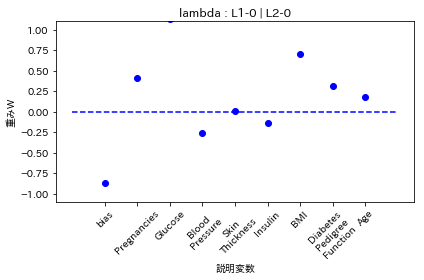

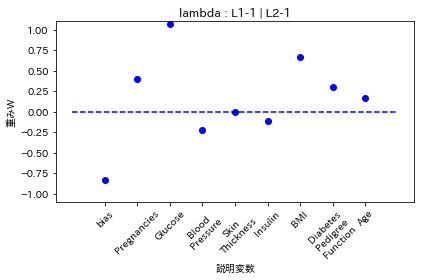

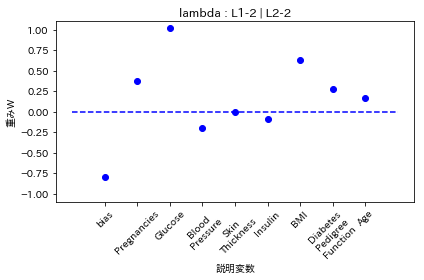

In [5]:
# 任意で変更
#lam_len = 50
lam_len = 3

for lam in range(lam_len):
    
    lams = [lam, lam]    # L1とL2が同じ割合 /GIF/elastic-same-50.gif
    #lams = [lam*2, lam] # L1がL2の２倍 /GIF/elastic-l1x2-50.gif
    #lams = [lam, lam*2] # L2がL1の２倍 /GIF/elastic-l2x2-50.gif
    
    print(lams)
    (w, r) = LogisticRegression(x_train, y_train.squeeze(), lams)
        
        
    # 以下、プロット
    plt.figure()
    im = plt.scatter(range(0,w.shape[0]), w, c='blue')
    plt.hlines([0], -1, 9, "blue", linestyles='dashed')
    plt.xticks([0,1,2,3,4,5,6,7,8], 
               ['bias', 'Pregnancies', 'Glucose', 'Blood\nPressure',
                'Skin\nThickness', 'Insulin', 'BMI', 'Diabetes\nPedigree\nFunction', 'Age'])
    plt.xticks(rotation=45)
    plt.xlabel("説明変数")
    plt.ylabel("重みW")
    plt.title("lambda : L1-{} | L2-{}".format(lams[0], lams[1]))
    plt.ylim([-1.1, 1.1])
    plt.tight_layout()
    plt.plot()
    # ディレクトリ tmp_gif_imgを作成し、GIF用画像保存
    # plt.savefig("tmp_gif_img/{0:03d}".format(i))

# ターミナルより、ffmpegを使用してGIFを作成
# ffmpeg -i tmp_gif_img/%03d.png -vf palettegen palette.png
# ffmpeg -f image2 -r 10 -i tmp_gif_img/%03d.png -i palette.png -filter_complex paletteuse l1-150.gif